In [1]:
import os
import sys
import re
import glob
from collections import defaultdict, Counter
from functools import reduce, partial
from itertools import combinations
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from scipy.stats import bootstrap, binom_test, entropy
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cosine, euclidean, pdist, squareform
from Bio import SeqIO
import tqdm

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp, CodonAnnotation, transcriptor, mutations_summary, calculate_mutspec
from pymutspec.io import read_rates, GenesStates
from pymutspec.constants import possible_sbs192, possible_sbs12

from utils import (complete_sbs192_columns, calc_edgewise_spectra, 
                   collapse_sbs192, get_cossim, get_eucdist)

%matplotlib inline

In [2]:
coda = CodonAnnotation(2)

## Mammals tree

### Filter bad rnd replics

In [50]:
nucls = list('ACGT')

data = []
for p in glob.glob('../data/alisim/generations_mam/*.fa'):
    raw_cond = p.split('/')[-1].split('.fa')[0]
    mdl, _, seq, _, replic = raw_cond.split('_')
    replic = int(replic)
    cond = f'{mdl}-{seq}'
    for rec in SeqIO.parse(p, 'fasta'):
        if rec.id == 'ROOT':
            seq = str(rec.seq)
            break
    data.append([raw_cond, cond, replic, seq])

human_cytb_seq   = set([x[3] for x in data if x[1].endswith('cytb')]).pop()
human_cytb_freqs = dict(Counter(human_cytb_seq))
human_cytb_freqs = [human_cytb_freqs[x]/len(human_cytb_seq) for x in nucls]

data = [x for x in data if x[1].endswith('rnd')]
df = pd.DataFrame(data, columns=['raw_cond', 'cond', 'replic', 'seq'])
df['len'] = df.seq.apply(len)
assert df['len'].nunique() == 1

freqs = pd.DataFrame(list(df.seq.apply(lambda x: dict(Counter(x))).values))
freqs = (freqs.T / freqs.sum(axis=1)).T.fillna(0.)

df = df.merge(freqs, left_index=True, right_index=True)
print(df.shape)
df.head()

(100, 9)


,raw_cond,cond,replic,seq,len,G,T,A,C
0,gtr_mam_rnd_replica_32,gtr-rnd,32,GGTAAAAGATTAGGAAAGGGTAGGATATGGGTAAGTATTTTATTTT...,1140,0.339474,0.280702,0.373684,0.006140
1,12.12_mam_rnd_replica_26,12.12-rnd,26,GGTACAAGATTATGAACGGGTCGTATATGTTTACGTATTTTATTTT...,1140,0.285088,0.365789,0.277193,0.071930
2,12.12_mam_rnd_replica_39,12.12-rnd,39,CCTAAAACATGAGCAAACCCGACGAGAGCCCTAACGAGGGGAGGTG...,1140,0.274561,0.042982,0.378070,0.304386
3,gtr_mam_rnd_replica_31,gtr-rnd,31,TTTCCCCTATTATTCACTCTTCTTCTCTTTTTCCTTCTTTTATTTT...,1140,0.017544,0.584211,0.157018,0.241228
4,gtr_mam_rnd_replica_46,gtr-rnd,46,GCTAAAACATTAGCAACGCCGCCGAGATCGGTACGGATTGGATTTT...,1140,0.262281,0.131579,0.296491,0.309649


In [51]:
base = 4
human_cytb_entropy = entropy(human_cytb_freqs, base=base)
human_cytb_entropy

0.956904812547667

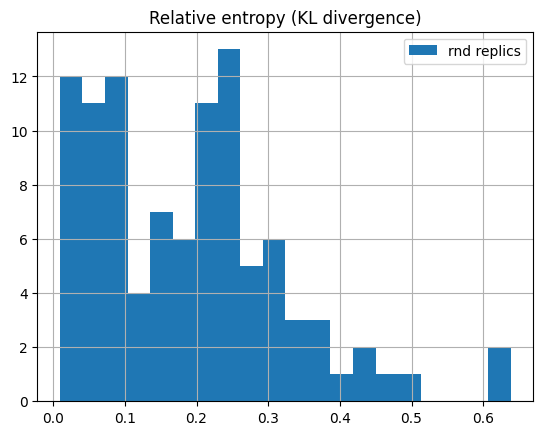

In [53]:
df['entropy'] = df[nucls].apply(partial(entropy, qk=human_cytb_freqs, base=base), axis=1)

df.entropy.hist(bins=20, label='rnd replics')
# plt.vlines(human_cytb_entropy, 0, 10, 'red', 'dashed', label='human cytb')
plt.title('Relative entropy (KL divergence)')
plt.legend()
plt.show()

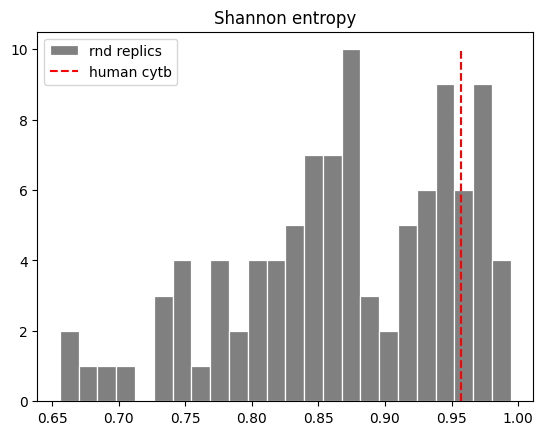

In [71]:
df['entropy'] = df[nucls].apply(partial(entropy, base=base), axis=1)

df.entropy.hist(bins=24, label='rnd replics', color='grey', lw=0.9, ec="w",)
plt.vlines(human_cytb_entropy, 0, 10, 'red', 'dashed', label='human cytb')
plt.title('Shannon entropy')
plt.legend()
plt.grid(False)
plt.savefig("../figures/alisim/rnd_replics_rootseq_entropy.pdf")
plt.show()

In [7]:
def find_polyN(seq: str):
    polyA = re.findall('A{6,}', seq)
    polyC = re.findall('C{6,}', seq)
    polyG = re.findall('G{6,}', seq)
    polyT = re.findall('T{6,}', seq)
    polys = polyA + polyC + polyG + polyT
    return polys

find_polyN(human_cytb_seq)

[]

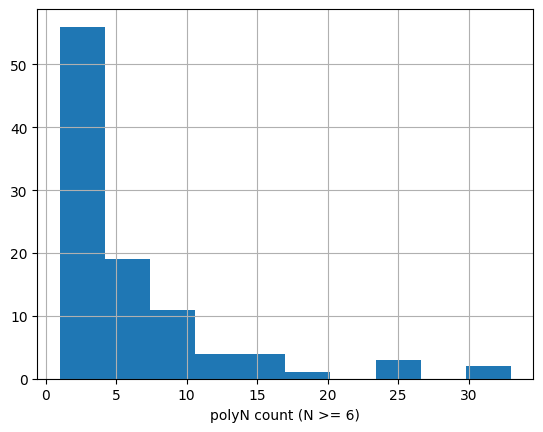

In [8]:
df['polyN_count'] = df.seq.apply(find_polyN).apply(len)

df['polyN_count'].hist()
plt.xlabel('polyN count (N >= 6)');

# check 

In [9]:
df[['entropy','polyN_count']].sort_values('entropy').head(20).T

,31,69,79,6,10,64,3,35,20,19,55,40,80,56,37,93,73,15,51,47
entropy,0.655818,0.657319,0.673015,0.697702,0.7025,0.729132,0.734816,0.73501,0.742582,0.747501,0.748125,0.75376,0.763865,0.772909,0.773456,0.775886,0.778656,0.793204,0.794735,0.802966
polyN_count,13.000000,33.000000,25.000000,33.000000,15.0000,8.000000,15.000000,15.00000,10.000000,24.000000,15.000000,12.00000,17.000000,12.000000,24.000000,10.000000,10.000000,13.000000,4.000000,6.000000


In [10]:
rnd_samples = df[df.entropy >= 0.9].raw_cond.values
rnd_samples

array(['12.12_mam_rnd_replica_26', 'gtr_mam_rnd_replica_46',
       '12.12_mam_rnd_replica_35', 'gtr_mam_rnd_replica_37',
       '12.12_mam_rnd_replica_13', 'gtr_mam_rnd_replica_11',
       '12.12_mam_rnd_replica_41', '12.12_mam_rnd_replica_28',
       '12.12_mam_rnd_replica_36', '12.12_mam_rnd_replica_47',
       'gtr_mam_rnd_replica_13', '12.12_mam_rnd_replica_45',
       'gtr_mam_rnd_replica_38', 'gtr_mam_rnd_replica_34',
       'gtr_mam_rnd_replica_12', 'gtr_mam_rnd_replica_43',
       '12.12_mam_rnd_replica_3', 'gtr_mam_rnd_replica_8',
       '12.12_mam_rnd_replica_1', '12.12_mam_rnd_replica_23',
       'gtr_mam_rnd_replica_5', 'gtr_mam_rnd_replica_15',
       'gtr_mam_rnd_replica_49', 'gtr_mam_rnd_replica_44',
       'gtr_mam_rnd_replica_39', 'gtr_mam_rnd_replica_40',
       '12.12_mam_rnd_replica_9', '12.12_mam_rnd_replica_44',
       'gtr_mam_rnd_replica_47', 'gtr_mam_rnd_replica_48',
       '12.12_mam_rnd_replica_7', '12.12_mam_rnd_replica_6',
       'gtr_mam_rnd_replica_30', 

### Load and Preprocess data

In [11]:
cols_rec_obs = ["Mut", "Label", "PosInGene", "ProbaFull", "RefNode", "AltNode"]
cols_gt_obs  = ["Mut", "Label", "PosInGene", "RefNode", "AltNode"]
cols_rec_exp = ["Mut", "Label", "Pos", "Proba", "Node"]
cols_gt_exp  = ["Mut", "Label", "Pos",  "Node"]

internal_mapping = {f"Node{x}":f"Node{x}" for x in range(5000)}


def compare_mam_spectra(
        cond, pcutoff=0.3, categories=[4, 5, 6], nmtypes_cutoff=10, 
        nobs_cuttof=10, metric_func=get_cossim, only_raw=False, only_spectra_gt=False,
    ):
    path_to_rates   = f"../data/alisim/spectra_reconstructed_mam/{cond}/IQTREE/anc.rate"
    path_to_mapping = f"../data/alisim/spectra_reconstructed_mam/{cond}/sequences/species_mapping.txt"

    path_to_rec_obs = f"../data/alisim/spectra_reconstructed_mam/{cond}/spectra_v3/mutations.tsv"
    path_to_rec_exp = f"../data/alisim/spectra_reconstructed_mam/{cond}/spectra_v3/expected_mutations.tsv"
    path_to_gt_obs  = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutations.tsv"
    path_to_gt_exp  = f"../data/alisim/spectra_groundtruth_mam/{cond}/expected_mutations.tsv"

    cat_lbl = 'cat' + ''.join(str(x) for x in categories)
    metric_name = metric_func.__name__.split("_")[-1]

    if os.path.exists(path_to_mapping) and \
            os.path.exists(path_to_rec_exp) and \
                os.path.exists(path_to_gt_exp):
        
        name2id_leaves = pd.read_csv(path_to_mapping, header=None, index_col=1, sep="\t")[0].to_dict()
        name2id = dict(**internal_mapping, **name2id_leaves)

        rec_obs = pd.read_csv(path_to_rec_obs, sep="\t", usecols=cols_rec_obs)
        rec_exp = pd.read_csv(path_to_rec_exp, sep="\t", usecols=cols_rec_exp)
        gt_obs  = pd.read_csv(path_to_gt_obs,  sep="\t", usecols=cols_gt_obs)
        gt_exp  = pd.read_csv(path_to_gt_exp,  sep="\t", usecols=cols_gt_exp)
        rates   = pd.read_csv(path_to_rates,   sep="\t", comment="#")

        rec_obs = rec_obs.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)
        rec_exp = rec_exp.merge(rates[["Site", "Cat"]], left_on="Pos", right_on="Site").drop("Pos", axis=1)
        gt_obs  = gt_obs.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)
        gt_exp  = gt_exp.merge(rates[["Site", "Cat"]], left_on="Pos", right_on="Site").drop("Pos", axis=1)

        # replace encoded node names
        gt_obs["AltNode"] = gt_obs.AltNode.map(name2id)

        if only_raw:
            return rec_obs, rec_exp, gt_obs, gt_exp

        #first of all gt, and then rec
        #prepare OBS gt
        gt_obs_all  = gt_obs[(gt_obs.Label >= 0) & (gt_obs.Cat.isin(categories))].assign(ProbaFull=1.0)
        gt_obs_syn  = gt_obs_all[(gt_obs_all.Label >= 1)]
        #prepare EXP gt
        gt_exp  = gt_exp[(gt_exp.Cat.isin(categories))].assign(Proba=1.0)
        gt_exp_all = gt_exp[(gt_exp.Label.astype("category") == "all")]
        gt_exp_syn = gt_exp[(gt_exp.Label.astype("category") == "syn")]
        #calc tree spectra gt
        gt_all_spectra12, gt_all_spectra192 = calc_edgewise_spectra(gt_obs_all, gt_exp_all, nmtypes_cutoff, nobs_cuttof, scale=False, both_12_and_192=True)
        gt_syn_spectra12, gt_syn_spectra192 = calc_edgewise_spectra(gt_obs_syn, gt_exp_syn, nmtypes_cutoff, nobs_cuttof, scale=False, both_12_and_192=True)
        
        if only_spectra_gt:
            return (
                pd.concat([
                    gt_all_spectra12.assign(MutType="all", Cond=cond).reset_index().set_index(["Cond", "MutType", "RefNode", "AltNode"]),
                    gt_syn_spectra12.assign(MutType="syn", Cond=cond).reset_index().set_index(["Cond", "MutType", "RefNode", "AltNode"]),
                ]),
                pd.concat([
                    gt_all_spectra192.assign(MutType="all", Cond=cond).reset_index().set_index(["Cond", "MutType", "RefNode", "AltNode"]),
                    gt_syn_spectra192.assign(MutType="syn", Cond=cond).reset_index().set_index(["Cond", "MutType", "RefNode", "AltNode"]),
                ]),
            )
        
        #prepare OBS rec
        rec_obs_all = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 0) & (rec_obs.Cat.isin(categories))]
        rec_obs_syn = rec_obs_all[(rec_obs_all.Label >= 1)]
        #prepare EXP rec
        rec_exp = rec_exp[(rec_exp.Proba > pcutoff) & (rec_exp.Cat.isin(categories))]
        rec_exp_all = rec_exp[(rec_exp.Label.astype("category") == "all")]
        rec_exp_syn = rec_exp[(rec_exp.Label.astype("category") == "syn")]
        #calc tree spectra rec
        rec_all_spectra12, rec_all_spectra192 = calc_edgewise_spectra(rec_obs_all, rec_exp_all, nmtypes_cutoff, nobs_cuttof, scale=False, both_12_and_192=True)
        rec_syn_spectra12, rec_syn_spectra192 = calc_edgewise_spectra(rec_obs_syn, rec_exp_syn, nmtypes_cutoff, nobs_cuttof, scale=False, both_12_and_192=True)
        
        #compare trees edge-wise using metric
        metric12_all  = metric_func(gt_all_spectra12,  rec_all_spectra12).rename(metric_name  + "12_all").reset_index()
        metric192_all = metric_func(gt_all_spectra192, rec_all_spectra192).rename(metric_name + "192_all").reset_index()
        metric12_syn  = metric_func(gt_syn_spectra12,  rec_syn_spectra12).rename(metric_name  + "12_syn").reset_index()
        metric192_syn = metric_func(gt_syn_spectra192, rec_syn_spectra192).rename(metric_name + "192_syn").reset_index()
    
        if len(metric12_all) == 0 or len(metric12_syn) == 0:
            return
        
        total_metric = metric12_all.merge(metric12_syn, "outer", on=["RefNode", "AltNode"])

        if len(metric192_all):
            total_metric = total_metric.merge(metric192_all, "outer", on=["RefNode", "AltNode"])
        if len(metric192_syn):
            total_metric = total_metric.merge(metric192_syn, "outer", on=["RefNode", "AltNode"])
        
        return total_metric.assign(Cond=cond, Cat=cat_lbl)

In [12]:
samples = [d.split("/")[-1] for d in glob.glob("../data/alisim/spectra_reconstructed_mam/*")]

rnd_samples = ['12.12_mam_rnd_replica_26', 'gtr_mam_rnd_replica_46',
       '12.12_mam_rnd_replica_35', 'gtr_mam_rnd_replica_37',
       '12.12_mam_rnd_replica_13', 'gtr_mam_rnd_replica_11',
       '12.12_mam_rnd_replica_41', '12.12_mam_rnd_replica_28',
       '12.12_mam_rnd_replica_36', '12.12_mam_rnd_replica_47',
       'gtr_mam_rnd_replica_13', '12.12_mam_rnd_replica_45',
       'gtr_mam_rnd_replica_38', 'gtr_mam_rnd_replica_34',
       'gtr_mam_rnd_replica_12', 'gtr_mam_rnd_replica_43',
       '12.12_mam_rnd_replica_3', 'gtr_mam_rnd_replica_8',
       '12.12_mam_rnd_replica_1', '12.12_mam_rnd_replica_23',
       'gtr_mam_rnd_replica_5', 'gtr_mam_rnd_replica_15',
       'gtr_mam_rnd_replica_49', 'gtr_mam_rnd_replica_44',
       'gtr_mam_rnd_replica_39', 'gtr_mam_rnd_replica_40',
       '12.12_mam_rnd_replica_9', '12.12_mam_rnd_replica_44',
       'gtr_mam_rnd_replica_47', 'gtr_mam_rnd_replica_48',
       '12.12_mam_rnd_replica_7', '12.12_mam_rnd_replica_6',
       'gtr_mam_rnd_replica_30', '12.12_mam_rnd_replica_49',
       '12.12_mam_rnd_replica_27', 'gtr_mam_rnd_replica_4',
       '12.12_mam_rnd_replica_38', 'gtr_mam_rnd_replica_41',
       '12.12_mam_rnd_replica_34']

samples_filtered = [x for x in samples if 'cytb' in x] + rnd_samples
samples = samples_filtered
len(samples)

139

### Check func

In [ ]:
one = compare_mam_spectra(samples[0], 0.3, [4,5,6], 5, 5)
print(samples[:5])
one

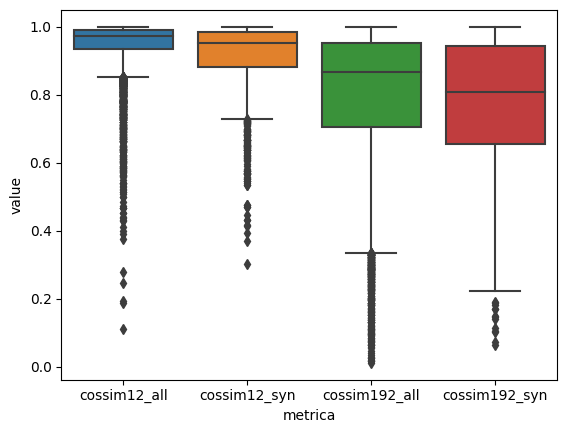

In [5]:
sns.boxplot(
    data=one.melt(
        ["RefNode", "AltNode"], 
        ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
        "metric"), 
    x="metric", y="value");

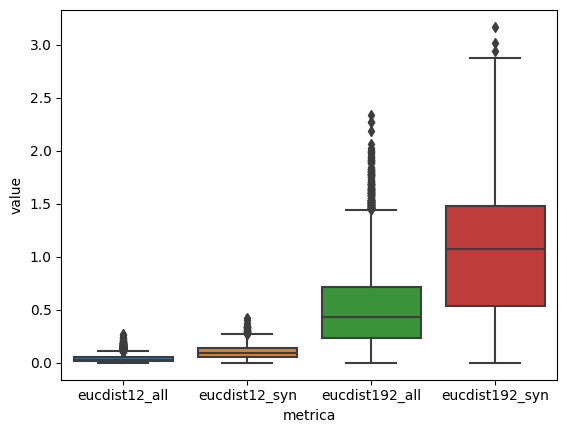

In [6]:
two = compare_mam_spectra(samples[0], 0.3, [4,5,6], 5, 5, get_eucdist)

sns.boxplot(
    data=two.melt(
        ["RefNode", "AltNode"], 
        ['eucdist12_all', 'eucdist12_syn', 'eucdist192_all','eucdist192_syn'], 
        "metric"), 
    x="metric", y="value");

In [18]:
three = compare_mam_spectra(samples[0], 0.3, [1,2,3,4,5,6], 5, 5, get_eucdist, only_spectra_gt=True)

In [23]:
three[1].head()

Mut                                                 A[A>C]A  A[A>C]C  \
Cond                    MutType RefNode  AltNode                       
gtr_mam_cytb_replica_18 all     Node10   Node11    0.066667     0.12   
                                         Node40    0.100000     0.12   
                                Node100  Node101   0.041667     0.00   
                                         RN_94     0.083333     0.00   
                                Node1000 Node1001  0.000000     0.00   

Mut                                                 A[A>C]G   A[A>C]T  \
Cond                    MutType RefNode  AltNode                        
gtr_mam_cytb_replica_18 all     Node10   Node11    0.066667  0.034483   
                                         Node40    0.066667  0.206897   
                                Node100  Node101   0.000000  0.000000   
                                         RN_94     0.045455  0.000000   
                                Node1000 Node1001  0.000000  0.000000   

Mut                                                C[A>C]A   C[A>C]C  C[A>C]G  \
Cond                    MutType RefNode  AltNode                                
gtr_mam_cytb_replica_18 all     Node10   Node11       0.08  0.148148    0.125   
                                         Node40       0.08  0.000000    0.000   
                                Node100  Node101      0.04  0.034483    0.000   
                                         RN_94        0.08  0.000000    0.000   
                                Node1000 Node1001     0.00  0.000000    0.000   

Mut                                                 C[A>C]T   G[A>C]A  \
Cond                    MutType RefNode  AltNode                        
gtr_mam_cytb_replica_18 all     Node10   Node11    0.105263  0.166667   
                                         Node40    0.000000  0.000000   
                                Node100  Node101   0.055556  0.000000   
                                         RN_94     0.111111  0.000000   
                                Node1000 Node1001  0.000000  0.047619   

Mut                                                 G[A>C]C  ...   C[T>G]G  \
Cond                    MutType RefNode  AltNode             ...             
gtr_mam_cytb_replica_18 all     Node10   Node11    0.052632  ...  0.000000   
                                         Node40    0.052632  ...  0.000000   
                                Node100  Node101   0.000000  ...  0.000000   
                                         RN_94     0.000000  ...  0.055556   
                                Node1000 Node1001  0.000000  ...  0.000000   

Mut                                                 C[T>G]T   G[T>G]A  \
Cond                    MutType RefNode  AltNode                        
gtr_mam_cytb_replica_18 all     Node10   Node11    0.000000  0.000000   
                                         Node40    0.050000  0.000000   
                                Node100  Node101   0.000000  0.000000   
                                         RN_94     0.041667  0.058824   
                                Node1000 Node1001  0.000000  0.000000   

Mut                                                 G[T>G]C   G[T>G]G  \
Cond                    MutType RefNode  AltNode                        
gtr_mam_cytb_replica_18 all     Node10   Node11    0.100000  0.142857   
                                         Node40    0.000000  0.000000   
                                Node100  Node101   0.000000  0.000000   
                                         RN_94     0.083333  0.000000   
                                Node1000 Node1001  0.000000  0.000000   

Mut                                                 G[T>G]T   T[T>G]A  \
Cond                    MutType RefNode  AltNode                        
gtr_mam_cytb_replica_18 all     Node10   Node11    0.000000  0.045455   
                                         Node40    0.000000  0.000000   
                                Node100 

### slightly explore data

In [12]:
rec_obs, rec_exp, gt_obs, gt_exp = compare_mam_spectra(samples[0], only_raw=True)

In [13]:
rec_obs[rec_obs.ProbaFull > 0.3].groupby(["Cat", "AltNode"]).ProbaFull.sum().mean(level=0)#.hist(bins=50)

Cat
1    1.812636
2    3.285983
3    4.415482
4    5.436690
5    7.287127
6    7.081877
Name: ProbaFull, dtype: float64

In [14]:
# TODO calculate IoU for each
a = gt_obs[(gt_obs.AltNode == "Node801") & (gt_obs.Label >= 0)]
b = rec_obs[(rec_obs.AltNode == "Node801") & (rec_obs.Label >= 0) & (rec_obs.ProbaFull > 0.3)]

c = pd.merge(a, b, "outer", on=['Mut', 'Label', 'Site'])
c

,Mut,Label,RefNode_x,AltNode_x,Site,Cat_x,ProbaFull,RefNode_y,AltNode_y,Cat_y
0,G[C>A]T,2,Node747,Node801,501,4.0,0.744982,Node747,Node801,4.0
1,A[G>T]C,0,Node747,Node801,635,5.0,0.941088,Node747,Node801,5.0
2,A[C>A]T,0,Node747,Node801,1112,5.0,NaN,NaN,NaN,NaN
3,A[C>A]C,0,Node747,Node801,126,6.0,0.912476,Node747,Node801,6.0
4,G[A>G]C,0,Node747,Node801,317,2.0,0.955379,Node747,Node801,2.0
5,T[G>C]T,0,Node747,Node801,552,6.0,0.841552,Node747,Node801,6.0
6,C[A>C]C,0,Node747,Node801,829,6.0,0.906378,Node747,Node801,6.0
7,C[A>C]C,0,Node747,Node801,5,1.0,0.936491,Node747,Node801,1.0
8,T[T>G]T,0,Node747,Node801,308,5.0,0.955369,Node747,Node801,5.0
9,A[G>A]A,0,Node747,Node801,340,5.0,0.934109,Node747,Node801,5.0


<AxesSubplot:>

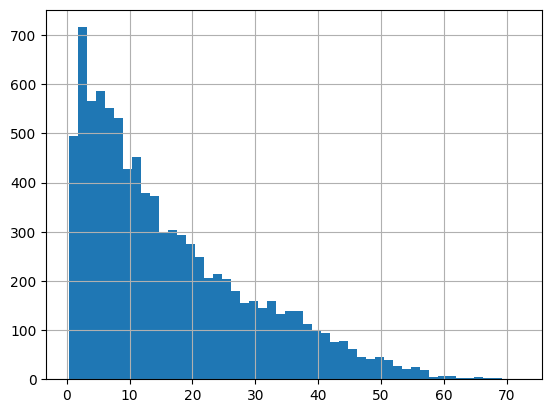

In [109]:
rec_obs[(rec_obs.ProbaFull > 0.3) & (rec_obs.Label >= 0) & (rec_obs.Cat >= 4)].groupby("AltNode").ProbaFull.sum().hist(bins=50)

<AxesSubplot:>

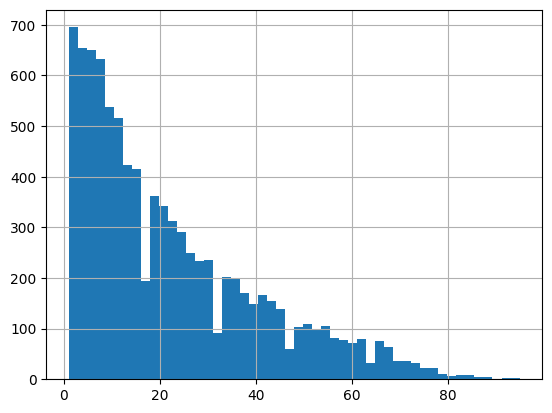

In [49]:
gt_obs[(gt_obs.Label >= 0) & (gt_obs.Cat >= 4)].groupby("AltNode").Mut.count().hist(bins=50)

#### OBS and EXP cossims

In [50]:
pcutoff = 0.3
cat_cutoff = 4

#prepare OBS
rec_obs_all = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 0) & (rec_obs.Cat >= cat_cutoff)]
gt_obs_all = gt_obs[(gt_obs.Label >= 0) & (gt_obs.Cat >= cat_cutoff)].assign(ProbaFull=1.0)

#prepare EXP
rec_exp_all = rec_exp[(rec_exp.Proba > pcutoff) & (rec_exp.Label.astype("category") == "all") & (rec_exp.Cat >= cat_cutoff)]
gt_exp_all = gt_exp[(gt_exp.Label.astype("category") == "all") & (gt_exp.Cat >= cat_cutoff)].assign(Proba=1.0)

Text(0.5, 1.0, 'distribution of cossim of OBSERVED: reconstructed VS ground truth 12 comp')

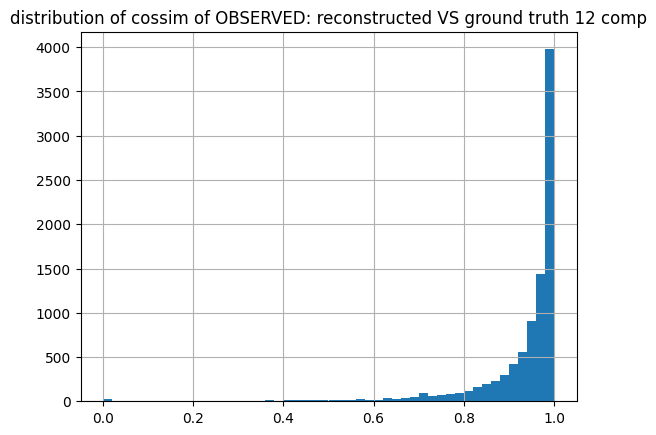

In [51]:
get_cossim(
    collapse_sbs192(rec_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack().fillna(0)[possible_sbs192]),
    collapse_sbs192(gt_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack().fillna(0)[possible_sbs192]),
).hist(bins=50)
plt.title("distribution of cossim of OBSERVED: reconstructed VS ground truth 12 comp")

Text(0.5, 1.0, 'distribution of cossim of EXPECTED: reconstructed VS ground truth 12 comp')

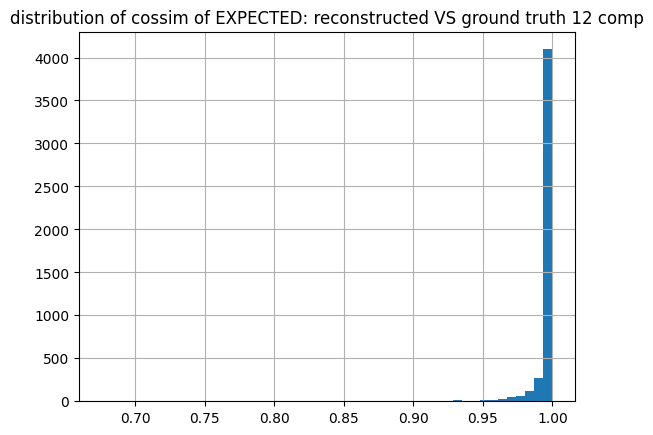

In [52]:
get_cossim(
    collapse_sbs192(rec_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack().fillna(0)[possible_sbs192]),
    collapse_sbs192(gt_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack().fillna(0)[possible_sbs192]),
).hist(bins=50)
plt.title("distribution of cossim of EXPECTED: reconstructed VS ground truth 12 comp")

Text(0.5, 1.0, 'distribution of cossim of OBSERVED: reconstructed VS ground truth 192 comp')

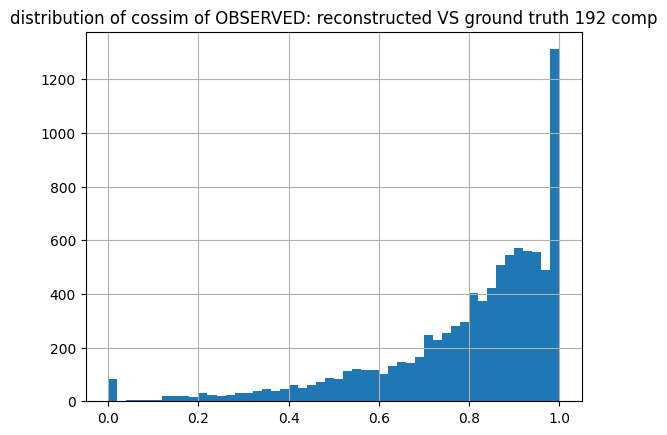

In [53]:
get_cossim(
    rec_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack(),
    gt_obs_all.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack(),
).hist(bins=50)
plt.title("distribution of cossim of OBSERVED: reconstructed VS ground truth 192 comp")

Text(0.5, 1.0, 'distribution of cossim of EXPECTED: reconstructed VS ground truth 192 comp')

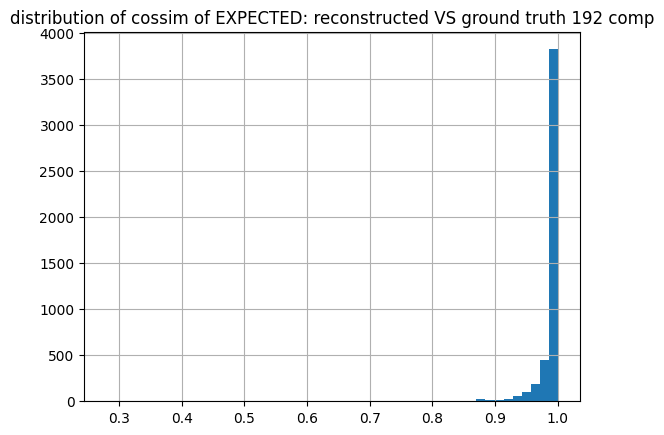

In [54]:
get_cossim(
    rec_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack(),
    gt_exp_all.groupby(["Node", "Mut"]).Proba.sum().unstack(),
).hist(bins=50)
plt.title("distribution of cossim of EXPECTED: reconstructed VS ground truth 192 comp")

OBS mutations were reconstructed with a lot of errors

### Compute cossim: grund truth (simulated) versus reconstructed

In [16]:
p = Pool(64)

In [33]:
raw_data456 = p.map(
    partial(compare_mam_spectra, categories=[4,5,6], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_cossim), 
    samples,
)

In [17]:
raw_data123 = p.map(
    partial(compare_mam_spectra, categories=[1,2,3], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_cossim), 
    samples,
)

In [28]:
raw_data4 = p.map(
    partial(compare_mam_spectra, categories=[4], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_cossim), 
    samples,
)

In [29]:
raw_data5 = p.map(
    partial(compare_mam_spectra, categories=[5], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_cossim), 
    samples,
)

In [30]:
raw_data6 = p.map(
    partial(compare_mam_spectra, categories=[6], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_cossim), 
    samples,
)

In [34]:
sum([isinstance(x, pd.DataFrame) for x in raw_data123])
# one replica has some reconstruction error

199

In [ ]:
cossim456 = pd.concat(raw_data456).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metric")
cossim456["replica"] = cossim456.Cond.apply(lambda x: x.split("_")[4])
cossim456["cond"]    = cossim456.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim456, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_cat456.png")

In [ ]:
cossim6 = pd.concat(raw_data6).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metric")
# cossim["mdl"] = cossim.Cond.apply(lambda x: x.split("_")[0])
# cossim["seq"] = cossim.Cond.apply(lambda x: x.split("_")[2])
cossim6["replica"] = cossim6.Cond.apply(lambda x: x.split("_")[4])
cossim6["cond"] = cossim6.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim6, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_cat6.png")

In [ ]:
cossim5 = pd.concat(raw_data5).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metric")
# cossim["mdl"] = cossim.Cond.apply(lambda x: x.split("_")[0])
# cossim["seq"] = cossim.Cond.apply(lambda x: x.split("_")[2])
cossim5["replica"] = cossim5.Cond.apply(lambda x: x.split("_")[4])
cossim5["cond"] = cossim5.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim5, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_cat5.png")

In [ ]:
cossim4 = pd.concat(raw_data4).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metric")
cossim4["replica"] = cossim4.Cond.apply(lambda x: x.split("_")[4])
cossim4["cond"] = cossim4.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim4, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_cat4.png")

In [ ]:
cossim123 = pd.concat(raw_data123).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metric")
cossim123["replica"] = cossim123.Cond.apply(lambda x: x.split("_")[4])
cossim123["cond"] = cossim123.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim123, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_cat123.png")

In [41]:
cossim = pd.concat(raw_data123 + raw_data4 + raw_data5 + raw_data6).melt(
    ["Cond", "Cat", "RefNode", "AltNode"], 
    ['cossim12_all', 'cossim12_syn', 'cossim192_all','cossim192_syn'], 
    "metric")
cossim["replica"] = cossim.Cond.apply(lambda x: x.split("_")[4])
cossim["cond"] = cossim.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])
cossim.head()

,Cond,Cat,RefNode,AltNode,metrica,value,replica,cond
0,gtr_mam_cytb_replica_18,cat123,Node10,Node11,cossim12_all,0.964086,18,gtr-cytb
1,gtr_mam_cytb_replica_18,cat123,Node10,Node40,cossim12_all,0.893056,18,gtr-cytb
2,gtr_mam_cytb_replica_18,cat123,Node100,RN_94,cossim12_all,0.991303,18,gtr-cytb
3,gtr_mam_cytb_replica_18,cat123,Node1003,RN_990,cossim12_all,0.998004,18,gtr-cytb
4,gtr_mam_cytb_replica_18,cat123,Node1004,RN_988,cossim12_all,0.999992,18,gtr-cytb


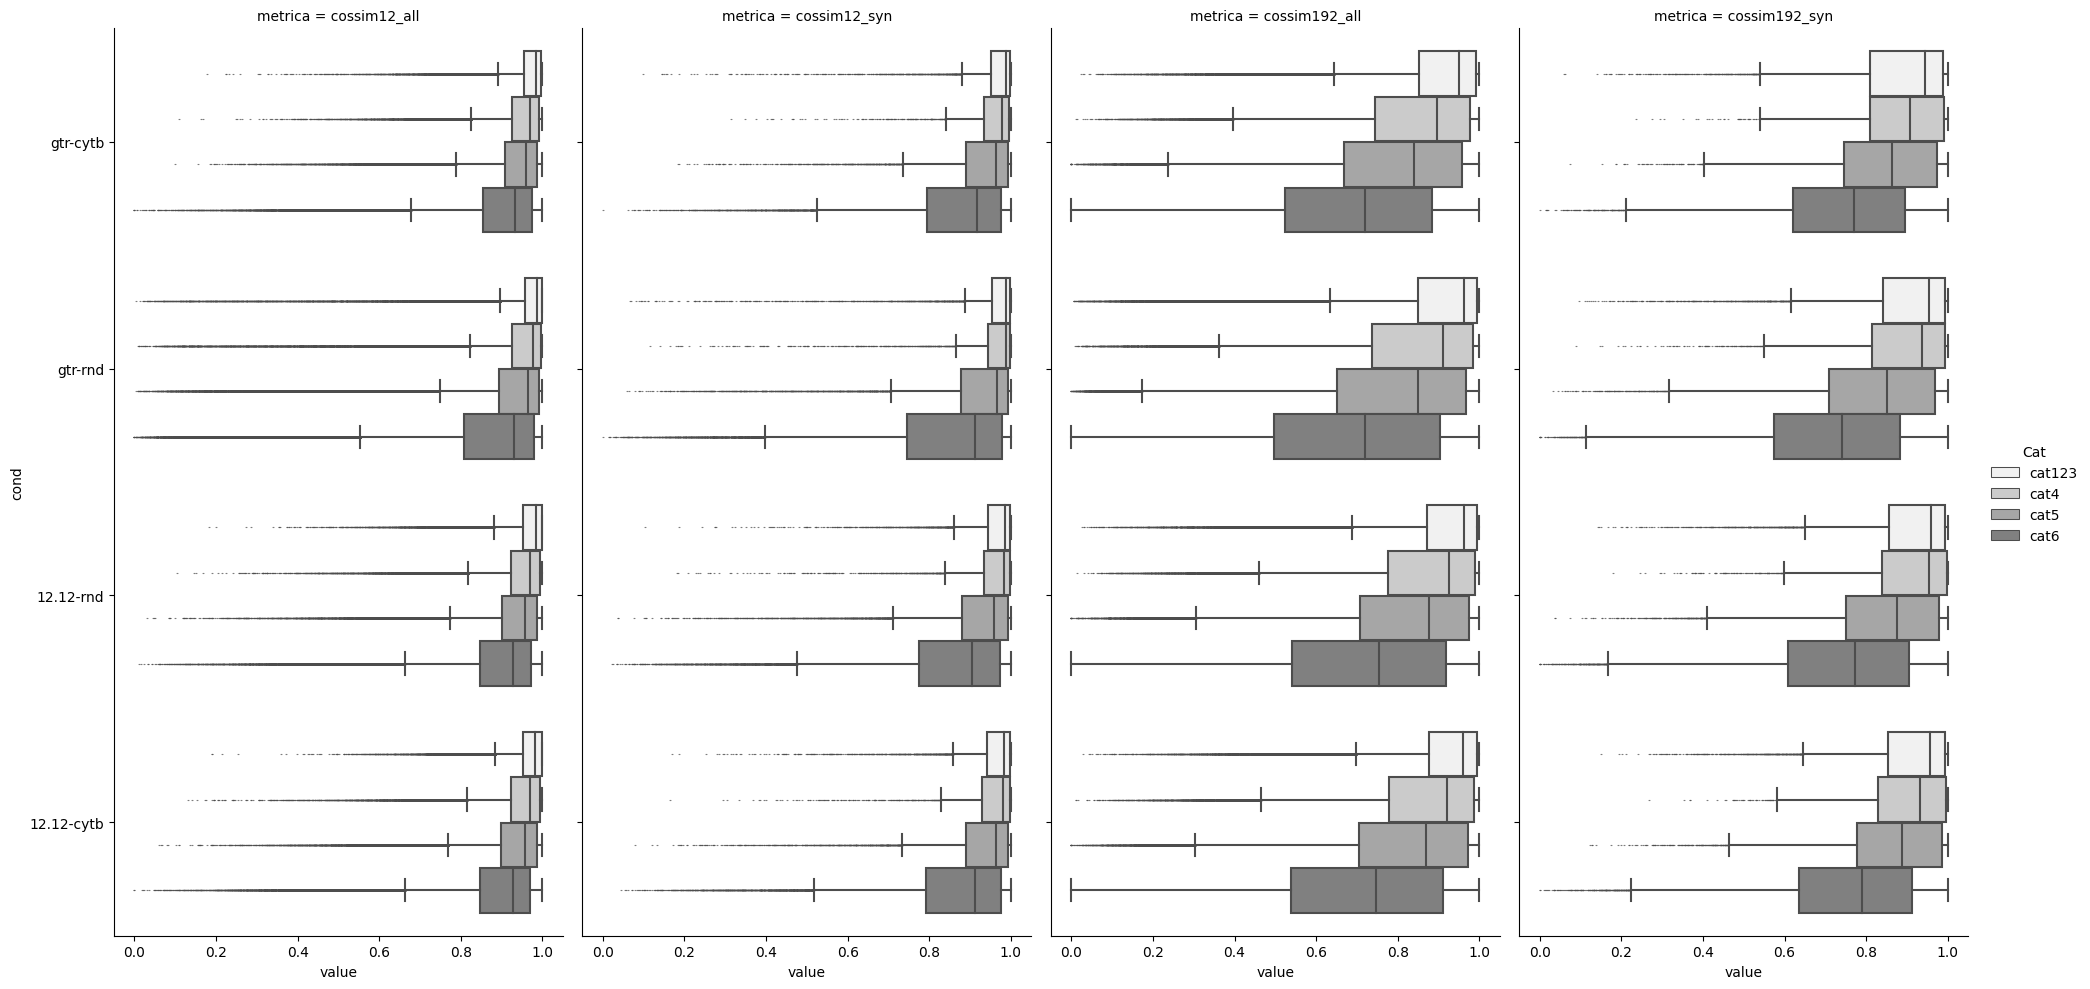

In [55]:
g = sns.catplot(
    data=cossim, x="value", hue="Cat", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=True, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/cossim_mam_full.png")

In [65]:
# MEDIAN
cossim.groupby(["cond", "Cat", "metric"]).value.mean().unstack().round(2)

metrica            cossim12_all  cossim12_syn  cossim192_all  cossim192_syn
cond       Cat                                                             
12.12-cytb cat123          0.96          0.95           0.91           0.90
           cat4            0.94          0.94           0.86           0.89
           cat5            0.93          0.92           0.81           0.86
           cat6            0.89          0.86           0.70           0.76
12.12-rnd  cat123          0.96          0.95           0.90           0.90
           cat4            0.94          0.94           0.86           0.90
           cat5            0.93          0.91           0.81           0.84
           cat6            0.89          0.84           0.70           0.74
gtr-cytb   cat123          0.96          0.95           0.89           0.88
           cat4            0.95          0.95           0.84           0.88
           cat5            0.93          0.92           0.79           0.84
           cat6            0.89          0.86           0.68           0.75
gtr-rnd    cat123          0.96          0.95           0.88           0.89
           cat4            0.93          0.94           0.83           0.88
           cat5            0.91          0.90           0.78           0.81
           cat6            0.85          0.83           0.68           0.71

In [74]:
cossim.groupby(["cond", "metric", "Cat"]).value.describe()\
    .rename_axis(index={"cond": "condition", "Cat": "category"})\
        .to_csv("../data/share/alisim_cossim_mam.csv", float_format="%g")

### Compute eucdist: grund truth (simulated) versus reconstructed

In [14]:
p = Pool(128)

In [16]:
# raw_data456 = p.map(
#     partial(compare_mam_spectra, categories=[4,5,6], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_eucdist), 
#     samples,
# )

In [17]:
raw_data123 = p.map(
    partial(compare_mam_spectra, categories=[1,2,3], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_eucdist), 
    samples,
)

In [18]:
sum([isinstance(x, pd.DataFrame) for x in raw_data123])
# one replica has some reconstruction error

137

In [19]:
raw_data4 = p.map(
    partial(compare_mam_spectra, categories=[4], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_eucdist), 
    samples,
)

In [20]:
raw_data5 = p.map(
    partial(compare_mam_spectra, categories=[5], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_eucdist), 
    samples,
)

In [21]:
raw_data6 = p.map(
    partial(compare_mam_spectra, categories=[6], nmtypes_cutoff=5, nobs_cuttof=5, metric_func=get_eucdist), 
    samples,
)

In [15]:
raw_spectra = p.map(
    partial(compare_mam_spectra, categories=[1,2,3,4,5,6], 
            nmtypes_cutoff=5, nobs_cuttof=5, only_spectra_gt=True), 
    samples,
)
replics_spectra12  = pd.concat([x[0] for x in raw_spectra if x]).astype(np.float32)
replics_spectra192 = pd.concat([x[1] for x in raw_spectra if x]).astype(np.float32)
del raw_spectra

In [16]:
data = []
i = 0
for mut_type in ["all", "syn"]:
    for cond1, cond2 in combinations(replics_spectra12.index.get_level_values(0).unique(),2):
        if cond1[:15] == cond2[:15]:
            i += 1
            _c = cond1.split("_")
            cond = _c[0] + "-" + _c[2]
            metric12 = get_eucdist(
                replics_spectra12.loc[cond1, mut_type], 
                replics_spectra12.loc[cond2, mut_type]
            )
            metric192 = get_eucdist(
                replics_spectra192.loc[cond1, mut_type], 
                replics_spectra192.loc[cond2, mut_type]
            )
            data.append(
                metric12.rename("value").reset_index()\
                    .assign(RawCond1=cond1, RawCond2=cond2, 
                            cond=cond, metric=f"eucdist12_{mut_type}")
            )
            data.append(
                metric192.rename("value").reset_index()\
                    .assign(RawCond1=cond1, RawCond2=cond2, 
                            cond=cond, metric=f"eucdist192_{mut_type}")
            )
            if i % 2000 == 0:
                print(i)
print(i)

2000
4000
5524


In [17]:
replic_vs_replic = pd.concat(data).assign(Cat="Replics")

In [18]:
replic_vs_replic.head()

,RefNode,AltNode,value,RawCond1,RawCond2,cond,metric,Cat
0,Node10,Node11,0.140834,gtr_mam_cytb_replica_18,gtr_mam_cytb_replica_2,gtr-cytb,eucdist12_all,Replics
1,Node10,Node40,0.092567,gtr_mam_cytb_replica_18,gtr_mam_cytb_replica_2,gtr-cytb,eucdist12_all,Replics
2,Node100,Node101,0.038275,gtr_mam_cytb_replica_18,gtr_mam_cytb_replica_2,gtr-cytb,eucdist12_all,Replics
3,Node100,RN_94,0.099164,gtr_mam_cytb_replica_18,gtr_mam_cytb_replica_2,gtr-cytb,eucdist12_all,Replics
4,Node1000,Node1001,0.041468,gtr_mam_cytb_replica_18,gtr_mam_cytb_replica_2,gtr-cytb,eucdist12_all,Replics


#### Plot eucdist distributions

##### Detailed

In [ ]:
cossim456 = pd.concat(raw_data456).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['eucdist12_all', 'eucdist12_syn', 'eucdist192_all','eucdist192_syn'], 
    "metric")
cossim456["replica"] = cossim456.Cond.apply(lambda x: x.split("_")[4])
cossim456["cond"]    = cossim456.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim456, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/eucdist_mam_cat456.png")
plt.close()

In [ ]:
cossim6 = pd.concat(raw_data6).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['eucdist12_all', 'eucdist12_syn', 'eucdist192_all','eucdist192_syn'], 
    "metric")
# cossim["mdl"] = cossim.Cond.apply(lambda x: x.split("_")[0])
# cossim["seq"] = cossim.Cond.apply(lambda x: x.split("_")[2])
cossim6["replica"] = cossim6.Cond.apply(lambda x: x.split("_")[4])
cossim6["cond"] = cossim6.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim6, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/eucdist_mam_cat6.png")
plt.close()

In [ ]:
cossim5 = pd.concat(raw_data5).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['eucdist12_all', 'eucdist12_syn', 'eucdist192_all','eucdist192_syn'], 
    "metric")
# cossim["mdl"] = cossim.Cond.apply(lambda x: x.split("_")[0])
# cossim["seq"] = cossim.Cond.apply(lambda x: x.split("_")[2])
cossim5["replica"] = cossim5.Cond.apply(lambda x: x.split("_")[4])
cossim5["cond"] = cossim5.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim5, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/eucdist_mam_cat5.png")
plt.close()

In [ ]:
cossim4 = pd.concat(raw_data4).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['eucdist12_all', 'eucdist12_syn', 'eucdist192_all','eucdist192_syn'], 
    "metric")
cossim4["replica"] = cossim4.Cond.apply(lambda x: x.split("_")[4])
cossim4["cond"] = cossim4.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim4, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")
multipletests
g.savefig("../figures/alisim/eucdist_mam_cat4.png")
plt.close()

In [ ]:
cossim123 = pd.concat(raw_data123).melt(
    ["Cond", "RefNode", "AltNode"], 
    ['eucdist12_all', 'eucdist12_syn', 'eucdist192_all','eucdist192_syn'], 
    "metric")
cossim123["replica"] = cossim123.Cond.apply(lambda x: x.split("_")[4])
cossim123["cond"] = cossim123.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])

g = sns.catplot(
    data=cossim123, x="value", hue="replica", col="metric", y="cond",
    kind="box", fliersize=0.2, legend=False, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/eucdist_mam_cat123.png")
plt.close()

##### Joint

In [26]:
cossim = pd.concat(raw_data123 + raw_data4 + raw_data5 + raw_data6).melt(
    ["Cond", "Cat", "RefNode", "AltNode"], 
    ['eucdist12_all', 'eucdist12_syn', 'eucdist192_all','eucdist192_syn'], 
    "metric")
cossim["cond"] = cossim.Cond.apply(lambda x: x.split("_")[0] + "-" + x.split("_")[2])
cossim.head()

,Cond,Cat,RefNode,AltNode,metric,value,cond
0,gtr_mam_cytb_replica_18,cat123,Node10,Node11,eucdist12_all,0.031454,gtr-cytb
1,gtr_mam_cytb_replica_18,cat123,Node10,Node40,eucdist12_all,0.024547,gtr-cytb
2,gtr_mam_cytb_replica_18,cat123,Node100,RN_94,eucdist12_all,0.007848,gtr-cytb
3,gtr_mam_cytb_replica_18,cat123,Node1003,RN_990,eucdist12_all,0.003486,gtr-cytb
4,gtr_mam_cytb_replica_18,cat123,Node1004,RN_988,eucdist12_all,0.000080,gtr-cytb


In [32]:
cossim.to_csv("../data/alisim/mam_cossim.csv", index=False)

In [19]:
cossim = pd.read_csv("../data/alisim/mam_cossim.csv")

In [20]:
cols = ['cond', 'metric', 'Cat', 'value', 'RefNode', 'AltNode']
df = pd.concat([cossim[cols], replic_vs_replic[cols]], ignore_index=True)

In [ ]:
g = sns.catplot(
    data=df, x="value", hue="Cat", col="metric", y="cond", sharex=False,
    kind="box", fliersize=0.2, legend=True, aspect=0.5, height=10, color="gray")

g.savefig("../figures/alisim/eucdist_mam.png")

In [21]:
df.shape, cossim.shape

((68717376, 6), (7947552, 7))

In [22]:
# _data_to_show = pd.concat([cossim[cols], replic_vs_replic[cols].sample(cossim.shape[0])], ignore_index=True)
_data_to_show = df

Rectangle(xy=(-0, -0), width=20, height=7, angle=0)
Rectangle(xy=(-0, -0), width=20, height=7, angle=0)
Rectangle(xy=(-0, -0), width=20, height=7, angle=0)
Rectangle(xy=(-0, -0), width=20, height=7, angle=0)
Rectangle(xy=(-0, -0), width=20, height=7, angle=0)


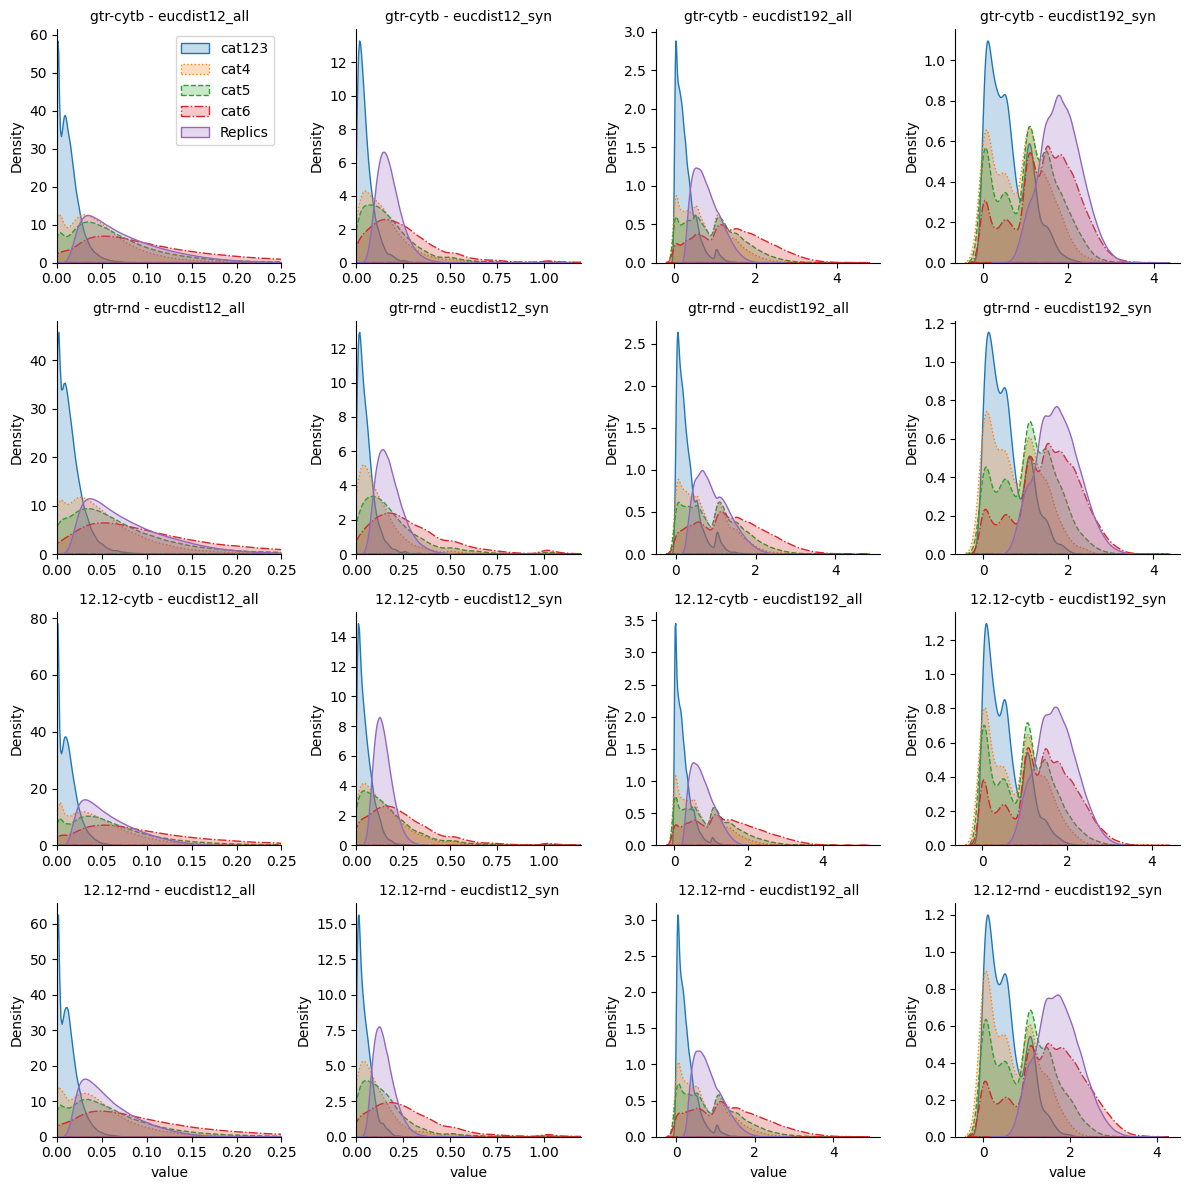

In [15]:
lss = ['-', ':', '--', '-.', '-']

g = sns.FacetGrid(
    data=_data_to_show, hue="Cat", col="metric", row="cond", 
    # palette=sns.color_palette("gray", _data_to_show.Cat.nunique())[::-1], 
    # palette="crest",
    height=3, sharex=False, sharey=False,
    col_order=['eucdist12_all', 'eucdist12_syn', 'eucdist192_all', 'eucdist192_syn'],
    row_order=['gtr-cytb', 'gtr-rnd', '12.12-cytb', '12.12-rnd'],
    hue_order=['cat123', 'cat4', 'cat5', 'cat6', 'Replics'],
)
g.map(sns.kdeplot, "value", common_norm=False, fill=True)
g.set_titles("{row_name} - {col_name}");
g.axes[0, 0].legend()
handles = g.axes[0, 0].legend_.legendHandles[::-1]
for ls, handle in zip(lss[::-1], handles):
    print(handle)
    handle.set_ls(ls)

for _cond in g.row_names:
    g.axes_dict[(_cond, 'eucdist12_all')].set_xbound(0, 0.25)
    g.axes_dict[(_cond, 'eucdist12_syn')].set_xbound(0, 1.2)

    for _metric in g.col_names:
        p = g.axes_dict[(_cond, _metric)]
        for line, ls in zip(p.collections, lss):
            line.set_linestyle(ls)

g.savefig("../figures/alisim/eucdist_mam_smooth.png")
plt.show()

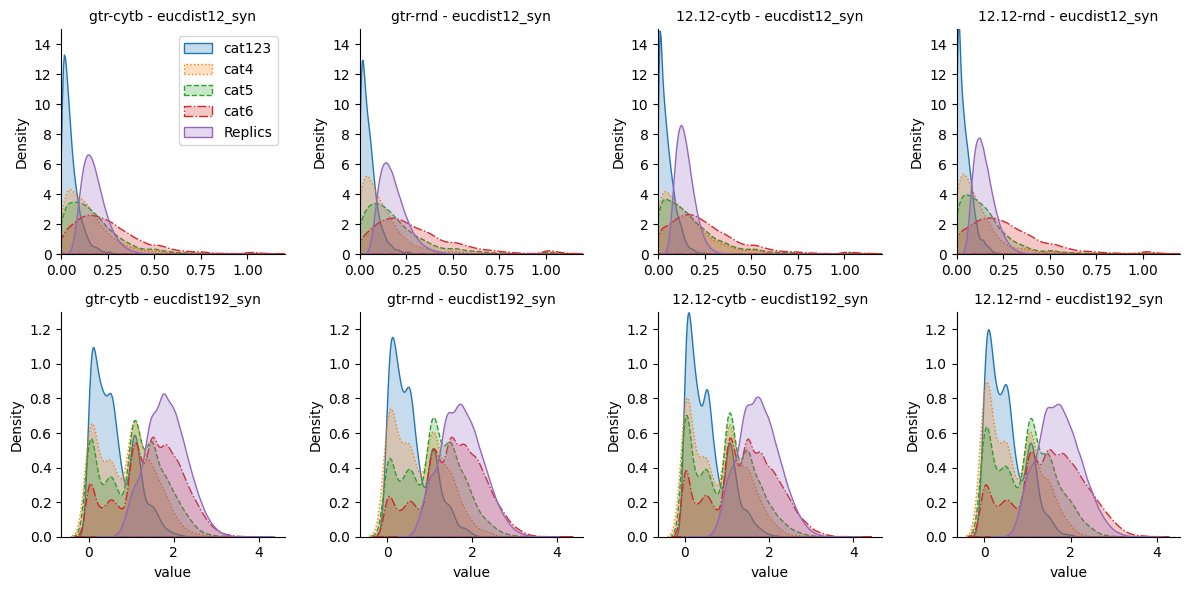

In [44]:
lss = ['-', ':', '--', '-.', '-']

g = sns.FacetGrid(
    data=_data_to_show, hue="Cat", row="metric", col="cond", 
    # palette=sns.color_palette("gray", _data_to_show.Cat.nunique())[::-1], 
    # palette="crest",
    height=3, sharex=False, sharey=False,
    row_order=['eucdist12_syn', 'eucdist192_syn'],
    col_order=['gtr-cytb', 'gtr-rnd', '12.12-cytb', '12.12-rnd'],
    hue_order=['cat123', 'cat4', 'cat5', 'cat6', 'Replics'],
)
g.map(sns.kdeplot, "value", common_norm=False, fill=True)
g.set_titles("{col_name} - {row_name}");
g.axes[0, 0].legend()
handles = g.axes[0, 0].legend_.legendHandles[::-1]
for ls, handle in zip(lss[::-1], handles):
    # print(handle)
    handle.set_ls(ls)

for _cond in g.col_names:
    g.axes_dict[('eucdist12_syn', _cond)].set_xbound(0, 1.2)
    g.axes_dict[('eucdist12_syn', _cond)].set_ybound(0, 15)
    g.axes_dict[('eucdist192_syn', _cond)].set_ybound(0, 1.3)

    for _metric in g.row_names:
        p = g.axes_dict[(_metric, _cond)]
        for line, ls in zip(p.collections, lss):
            line.set_linestyle(ls)

g.savefig("../figures/alisim/eucdist_mam_smooth_syn.png")
plt.show()

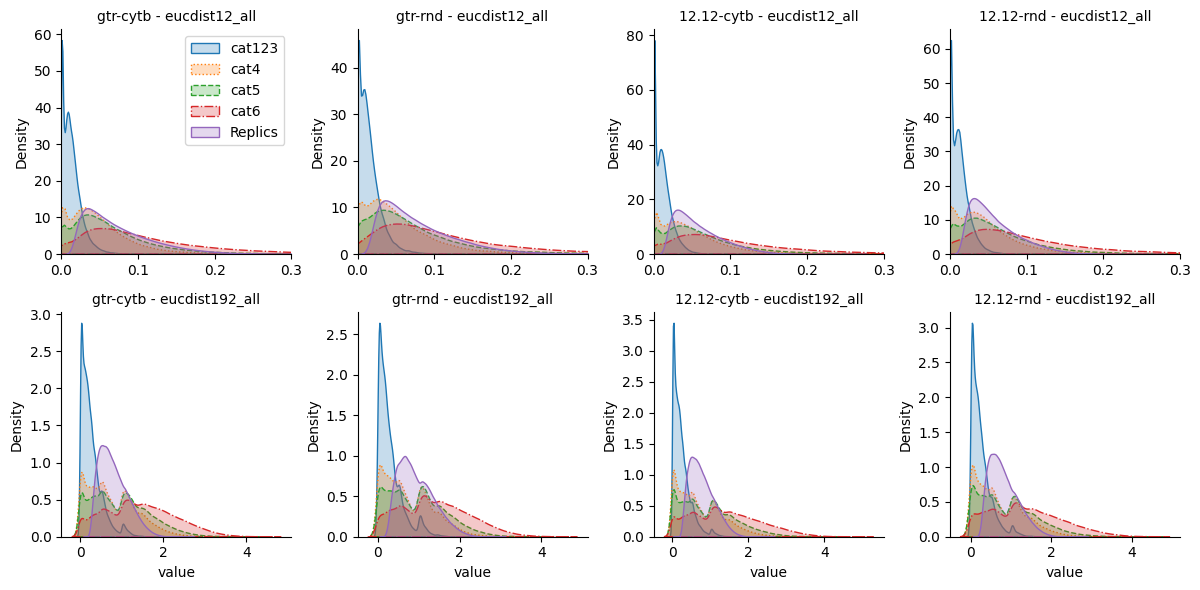

In [45]:
lss = ['-', ':', '--', '-.', '-']

g = sns.FacetGrid(
    data=_data_to_show, hue="Cat", row="metric", col="cond", 
    # palette=sns.color_palette("gray", _data_to_show.Cat.nunique())[::-1], 
    # palette="crest",
    height=3, sharex=False, sharey=False,
    row_order=['eucdist12_all', 'eucdist192_all'],
    col_order=['gtr-cytb', 'gtr-rnd', '12.12-cytb', '12.12-rnd'],
    hue_order=['cat123', 'cat4', 'cat5', 'cat6', 'Replics'],
)
g.map(sns.kdeplot, "value", common_norm=False, fill=True)
g.set_titles("{col_name} - {row_name}");
g.axes[0, 0].legend()
handles = g.axes[0, 0].legend_.legendHandles[::-1]
for ls, handle in zip(lss[::-1], handles):
    # print(handle)
    handle.set_ls(ls)

for _cond in g.col_names:
    g.axes_dict[('eucdist12_all', _cond)].set_xbound(0, 0.3)
    # g.axes_dict[('eucdist192_all', _cond)].set_ybound(0, 1.5)

    for _metric in g.row_names:
        p = g.axes_dict[(_metric, _cond)]
        for line, ls in zip(p.collections, lss):
            line.set_linestyle(ls)

g.savefig("../figures/alisim/eucdist_mam_smooth_all.png")
plt.show()

#### Derive number of data points (edges) around *reference* distribution

In [29]:
rquantiles=replic_vs_replic.groupby(['cond','metric'])['value'].quantile([0.05,0.95]).unstack().reset_index()
rquantiles

,cond,metric,0.05,0.95
0,12.12-cytb,eucdist12_all,0.020085,0.122230
1,12.12-cytb,eucdist12_syn,0.074951,0.236964
2,12.12-cytb,eucdist192_all,0.335840,1.374595
3,12.12-cytb,eucdist192_syn,0.986286,2.572852
4,12.12-rnd,eucdist12_all,0.020128,0.123670
5,12.12-rnd,eucdist12_syn,0.071771,0.254874
6,12.12-rnd,eucdist192_all,0.341365,1.503432
7,12.12-rnd,eucdist192_syn,0.948923,2.592165
8,gtr-cytb,eucdist12_all,0.022334,0.168775
9,gtr-cytb,eucdist12_syn,0.085944,0.303229


In [30]:
rquantiles

,cond,metric,0.05,0.95
0,12.12-cytb,eucdist12_all,0.020085,0.122230
1,12.12-cytb,eucdist12_syn,0.074951,0.236964
2,12.12-cytb,eucdist192_all,0.335840,1.374595
3,12.12-cytb,eucdist192_syn,0.986286,2.572852
4,12.12-rnd,eucdist12_all,0.020128,0.123670
5,12.12-rnd,eucdist12_syn,0.071771,0.254874
6,12.12-rnd,eucdist192_all,0.341365,1.503432
7,12.12-rnd,eucdist192_syn,0.948923,2.592165
8,gtr-cytb,eucdist12_all,0.022334,0.168775
9,gtr-cytb,eucdist12_syn,0.085944,0.303229


In [31]:
cossim2 = cossim.merge(rquantiles, on=['cond', 'metric'])

In [32]:
cossim2['more_than_0.95'] = (cossim2['value'] > cossim2[0.95]).astype(int)
cossim2['less_than_0.05'] = (cossim2['value'] < cossim2[0.05]).astype(int)
cossim2['total'] = (~cossim2['value'].isna()).astype(int)

In [33]:
cossim2.head()

,Cond,Cat,RefNode,AltNode,metric,value,cond,0.05,0.95,more_than_0.95,less_than_0.05,total
0,gtr_mam_cytb_replica_18,cat123,Node10,Node11,eucdist12_all,0.031454,gtr-cytb,0.022334,0.168775,0,0,1
1,gtr_mam_cytb_replica_18,cat123,Node10,Node40,eucdist12_all,0.024547,gtr-cytb,0.022334,0.168775,0,0,1
2,gtr_mam_cytb_replica_18,cat123,Node100,RN_94,eucdist12_all,0.007848,gtr-cytb,0.022334,0.168775,0,1,1
3,gtr_mam_cytb_replica_18,cat123,Node1003,RN_990,eucdist12_all,0.003486,gtr-cytb,0.022334,0.168775,0,1,1
4,gtr_mam_cytb_replica_18,cat123,Node1004,RN_988,eucdist12_all,0.000080,gtr-cytb,0.022334,0.168775,0,1,1


In [34]:
cossim2.groupby(['cond', 'metric', 'Cat'])[['more_than_0.95', 'less_than_0.05']].sum()

more_than_0.95  less_than_0.05
cond       metric         Cat                                   
12.12-cytb eucdist12_all  cat123              15          115086
                          cat4              6584           36559
                          cat5             21739           38308
                          cat6             84287           24931
           eucdist12_syn  cat123              59            6915
...                                          ...             ...
gtr-rnd    eucdist192_all cat6             35656           12779
           eucdist192_syn cat123               0            2743
                          cat4                 0             879
                          cat5                38            1917
                          cat6              1151            3633

[64 rows x 2 columns]

In [35]:
test = cossim2.groupby(['cond', 'Cat', 'metric'])[['more_than_0.95', 'less_than_0.05', 'total']].sum()
test['more_than_0.95'] /= test['total']
test['less_than_0.05'] /= test['total']

In [40]:
a = (test['more_than_0.95'].unstack()).round(4)
a.to_csv("../data/share/alisim_eucdist_mam_more_than_95percentile.csv", float_format="%g")
a

metric             eucdist12_all  eucdist12_syn  eucdist192_all  \
cond       Cat                                                    
12.12-cytb cat123         0.0001         0.0068          0.0022   
           cat4           0.0526         0.1954          0.1497   
           cat5           0.1144         0.2515          0.2524   
           cat6           0.3018         0.4384          0.4819   
12.12-rnd  cat123         0.0002         0.0011          0.0022   
           cat4           0.0469         0.0976          0.1067   
           cat5           0.1063         0.1646          0.1949   
           cat6           0.2844         0.4483          0.4130   
gtr-cytb   cat123         0.0000         0.0047          0.0023   
           cat4           0.0128         0.1001          0.1427   
           cat5           0.0425         0.1520          0.2448   
           cat6           0.1842         0.3148          0.4817   
gtr-rnd    cat123         0.0003         0.0034          0.0009   
           cat4           0.0192         0.0632          0.0612   
           cat5           0.0561         0.1658          0.1352   
           cat6           0.1772         0.3528          0.3346   

metric             eucdist192_syn  
cond       Cat                     
12.12-cytb cat123          0.0000  
           cat4            0.0016  
           cat5            0.0087  
           cat6            0.0559  
12.12-rnd  cat123          0.0000  
           cat4            0.0000  
           cat5            0.0034  
           cat6            0.0813  
gtr-cytb   cat123          0.0001  
           cat4            0.0015  
           cat5            0.0059  
           cat6            0.0402  
gtr-rnd    cat123          0.0000  
           cat4            0.0000  
           cat5            0.0073  
           cat6            0.0590

In [41]:
a = (test['less_than_0.05'].unstack()).round(4)
a.to_csv("../data/share/alisim_eucdist_mam_less_than_5percentile.csv", float_format="%g")
a

metric             eucdist12_all  eucdist12_syn  eucdist192_all  \
cond       Cat                                                    
12.12-cytb cat123         0.8034         0.7912          0.7554   
           cat4           0.2921         0.3696          0.3294   
           cat5           0.2016         0.3127          0.2472   
           cat6           0.0893         0.1544          0.1234   
12.12-rnd  cat123         0.7860         0.8019          0.7416   
           cat4           0.2904         0.4710          0.3475   
           cat5           0.2084         0.3192          0.2652   
           cat6           0.0954         0.1312          0.1359   
gtr-cytb   cat123         0.8129         0.8326          0.7298   
           cat4           0.2776         0.3967          0.2891   
           cat5           0.1960         0.3147          0.2116   
           cat6           0.0833         0.1657          0.1007   
gtr-rnd    cat123         0.7876         0.8209          0.7153   
           cat4           0.2987         0.4847          0.3272   
           cat5           0.2077         0.2804          0.2422   
           cat6           0.0950         0.1289          0.1199   

metric             eucdist192_syn  
cond       Cat                     
12.12-cytb cat123          0.7826  
           cat4            0.5313  
           cat5            0.4285  
           cat6            0.2403  
12.12-rnd  cat123          0.7866  
           cat4            0.6110  
           cat5            0.4369  
           cat6            0.2164  
gtr-cytb   cat123          0.7966  
           cat4            0.5803  
           cat5            0.4502  
           cat6            0.2677  
gtr-rnd    cat123          0.7677  
           cat4            0.5613  
           cat5            0.3684  
           cat6            0.1863

In [63]:
# MEDIAN
cossim.groupby(["cond", "Cat", "metric"]).value.mean().unstack().round(2)

metrica            eucdist12_all  eucdist12_syn  eucdist192_all  eucdist192_syn
cond       Cat                                                                 
12.12-cytb cat123           0.01           0.05            0.24            0.53
           cat4             0.05           0.15            0.72            0.79
           cat5             0.06           0.17            0.92            0.97
           cat6             0.10           0.25            1.41            1.40
12.12-rnd  cat123           0.01           0.04            0.25            0.51
           cat4             0.04           0.10            0.68            0.68
           cat5             0.06           0.16            0.87            0.99
           cat6             0.10           0.26            1.33            1.43
gtr-cytb   cat123           0.01           0.05            0.26            0.58
           cat4             0.05           0.14            0.77            0.87
           cat5             0.06           0.18            0.97            1.06
           cat6             0.11           0.26            1.43            1.45
gtr-rnd    cat123           0.02           0.06            0.28            0.49
           cat4             0.06           0.12            0.64            0.70
           cat5             0.08           0.18            0.82            0.97
           cat6             0.14           0.29            1.21            1.39

In [64]:
cossim.groupby(["cond", "metric", "Cat"]).value.describe()\
    .rename_axis(index={"cond": "condition", "Cat": "category"})\
        .to_csv("../data/share/alisim_eucdist_mam.csv", float_format="%g")

### Correlate edge cossim versus length

In [99]:
from ete3 import PhyloTree

path_to_tree = "../data/alisim/generations_mam/gtr_mam_cytb_replica_1.full.treefile"
tree = PhyloTree(path_to_tree, format=1)

edges = []
for i, node in enumerate(tree.iter_descendants()):
    # print(node.name, node.up.name, node.dist, )
    closest_leaf, d_to_leaf = node.up.get_closest_leaf()
    edges.append([
        node.up.name, 
        node.name, 
        node.dist, 
        closest_leaf.name, 
        d_to_leaf,
    ])
    # if i == 10:
    #     break

edges_df = pd.DataFrame(edges, columns=["RefNode", "AltNode", "d", "closest_leaf", "d_to_leaf"])
edges_df

,RefNode,AltNode,d,closest_leaf,d_to_leaf
0,ROOT,OUTGRP,1.50000,OUTGRP,1.50000
1,ROOT,Node4705,0.01000,OUTGRP,1.50000
2,Node4705,Node2,1.35799,gerbillus_occiduus,2.02331
3,Node4705,Node4,0.60502,gerbillus_occiduus,2.02331
4,Node2,Node3,0.54029,tachyglossus_aculeatus,0.66537
...,...,...,...,...,...
9405,Node1833,artibeus_planirostris_grenadensis,0.00338,artibeus_planirostris_fallax,0.00338
9406,Node3018,peromyscus_polionotus_peninsularis,0.00077,peromyscus_polionotus_peninsularis,0.00077
9407,Node3018,peromyscus_polionotus_trissyllepsis,0.00077,peromyscus_polionotus_peninsularis,0.00077
9408,Node3019,peromyscus_polionotus_ammobates,0.00092,peromyscus_polionotus_ammobates,0.00092


In [103]:
# cossim = 
pd.concat(raw_data).merge(edges_df[["AltNode", "d", "d_to_leaf"]], on="AltNode").corr("spearman")

,cossim12_all,cossim12_syn,cossim192_all,cossim192_syn,d,d_to_leaf
cossim12_all,1.000000,0.540121,0.671038,0.475829,-0.016756,-0.426740
cossim12_syn,0.540121,1.000000,0.534482,0.656736,-0.308253,-0.456969
cossim192_all,0.671038,0.534482,1.000000,0.659227,-0.267922,-0.625622
cossim192_syn,0.475829,0.656736,0.659227,1.000000,-0.407494,-0.562619
d,-0.016756,-0.308253,-0.267922,-0.407494,1.000000,0.638205
d_to_leaf,-0.426740,-0.456969,-0.625622,-0.562619,0.638205,1.000000


### derive entropy of anc states

In [ ]:
accuracy  = []

colnames = ['Node', 'Site', 'State', 'p_A', 'p_C', 'p_G', 'p_T']
dtypes = {
    'Site': np.int32,
    'p_A': np.float32,
    'p_C': np.float32,
    'p_G': np.float32,
    'p_T': np.float32,
}
i = 0
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_mam/*")):
    i += 1
    cond = d.split("/")[-1]
    path_to_rec_states = os.path.join(d, "IQTREE/iqtree_anc.state")
    path_to_rec_rates = os.path.join(d, "IQTREE/anc.rate")
    path_to_gt_states  = f"../data/alisim/generations_mam/{cond}.fa"


    if os.path.exists(path_to_gt_states) and os.path.exists(path_to_rec_states):
        rec = pd.read_csv(path_to_rec_states, sep="\t", usecols=colnames, dtype=dtypes, index_col=[0,1])
        rate = pd.read_csv(path_to_rec_rates, sep='\t', comment="#", index_col=0)
        rec = rec.merge(rate[["Cat"]], right_index=True, left_index=True)
        aln = SeqIO.parse(path_to_gt_states, "fasta")
        gt_data = []
        for seq in aln:
            node = seq.id
            if node.startswith("Node"):
                one = pd.DataFrame({
                    "Node":[node for _ in range(len(seq))], 
                    "Site":np.arange(1, len(seq)+1), 
                    "StateGt": list(seq.seq)})
                gt_data.append(one)
        gt = pd.concat(gt_data, ignore_index=True)
        # del gt_data
        df = rec.merge(gt, right_on=["Node", "Site"], left_index=True)
        # acc = (df.State == df.StateGt).sum() / len(df)
        df["is_eq"] = (df.State == df.StateGt).astype(np.int8)
        acc = df.groupby(["Node", "Cat"]).is_eq.value_counts(normalize=True).unstack()[1].rename("Acc").reset_index().assign(Cond=cond)
        accuracy.append(acc)
        # if acc < 0.9:
        #     print(f"WARNING! low accuracy: {acc:.3f} in {cond}")

    # if i == 6:
    #     break

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [34:53<00:00, 10.47s/it]


In [ ]:
df = pd.concat(accuracy)
print(df.shape)
df.head()

(6538560, 4)


,Node,Cat,Acc,Cond
0,Node10,0,1.000000,gtr_mam_cytb_replica_18
1,Node10,1,1.000000,gtr_mam_cytb_replica_18
2,Node10,2,0.995000,gtr_mam_cytb_replica_18
3,Node10,3,0.972067,gtr_mam_cytb_replica_18
4,Node10,4,0.924051,gtr_mam_cytb_replica_18


In [ ]:
df[df.Cat == 7].Cond.value_counts()

12.12_mam_cytb_replica_17    4704
gtr_mam_cytb_replica_45      4704
gtr_mam_cytb_replica_27      4704
Name: Cond, dtype: int64

In [ ]:
df.groupby(["Cond", "Cat"]).Acc.describe().round(2)

count  mean   std   min   25%   50%   75%  max
Cond                     Cat                                                 
12.12_mam_cytb_replica_0 0    4704.0  1.00  0.00  1.00  1.00  1.00  1.00  1.0
                         1    4704.0  1.00  0.00  0.76  1.00  1.00  1.00  1.0
                         2    4704.0  1.00  0.01  0.47  1.00  1.00  1.00  1.0
                         3    4704.0  0.99  0.02  0.39  0.99  1.00  1.00  1.0
                         4    4704.0  0.98  0.03  0.33  0.98  1.00  1.00  1.0
...                              ...   ...   ...   ...   ...   ...   ...  ...
gtr_mam_rnd_replica_9    2    4704.0  0.99  0.02  0.64  0.99  1.00  1.00  1.0
                         3    4704.0  0.98  0.03  0.64  0.98  1.00  1.00  1.0
                         4    4704.0  0.96  0.06  0.52  0.96  0.99  1.00  1.0
                         5    4704.0  0.93  0.08  0.45  0.90  0.97  0.99  1.0
                         6    4704.0  0.86  0.13  0.43  0.77  0.90  0.97  1.0

[1390 rows x 8 columns]

<AxesSubplot:xlabel='Cat', ylabel='Acc'>

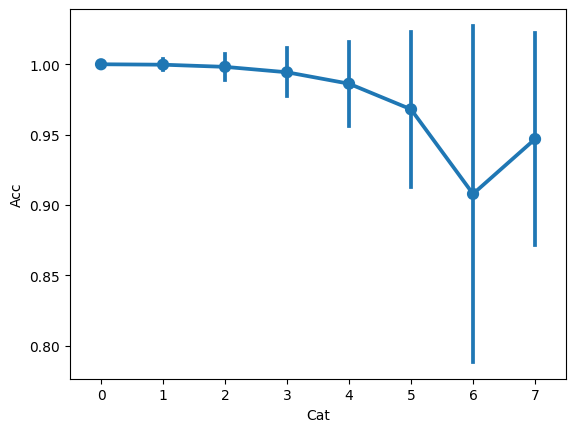

In [ ]:
sns.pointplot(data=df, x="Cat", y="Acc", ci="sd", )

<AxesSubplot:xlabel='Cat', ylabel='Acc'>

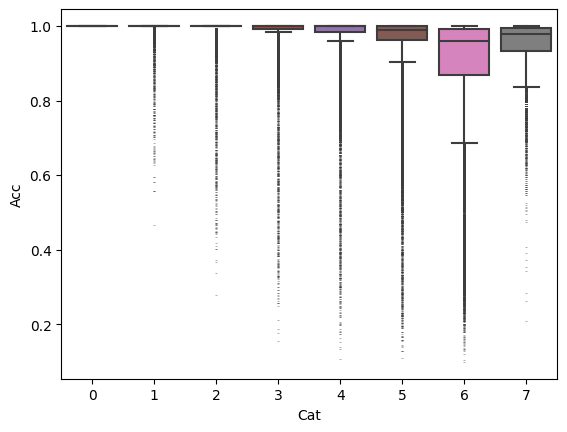

In [ ]:
# plt.figure(figsize=(18, 6))
sns.boxplot(data=df, y="Acc", x="Cat", fliersize=0.1)

### IoU for reconstructed mutations

In [160]:
cols_rec_obs = ["Mut", "Label", "PosInGene", "ProbaFull", "AltNode"]
cols_gt_obs  = ["Mut", "Label", "PosInGene", "AltNode"]

internal_mapping = {f"Node{x}":f"Node{x}" for x in range(5000)}


def obs_iou(cond, pcutoff=0.3, cat_cutoff=4,  only_raw=False):
    path_to_rates   = f"../data/alisim/spectra_reconstructed_mam/{cond}/IQTREE/anc.rate"
    path_to_mapping = f"../data/alisim/spectra_reconstructed_mam/{cond}/sequences/species_mapping.txt"

    path_to_rec_obs = f"../data/alisim/spectra_reconstructed_mam/{cond}/spectra_v3/mutations.tsv"
    path_to_gt_obs  = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutations.tsv"

    if os.path.exists(path_to_mapping) and os.path.exists(path_to_rec_obs) and os.path.exists(path_to_gt_obs):
        name2id_leaves = pd.read_csv(path_to_mapping, header=None, index_col=1, sep="\t")[0].to_dict()
        name2id = dict(**internal_mapping, **name2id_leaves)

        rec_obs = pd.read_csv(path_to_rec_obs, sep="\t", usecols=cols_rec_obs)
        gt_obs  = pd.read_csv(path_to_gt_obs,  sep="\t", usecols=cols_gt_obs)
        rates   = pd.read_csv(path_to_rates,   sep="\t", comment="#")

        # rec_obs = rec_obs.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)
        # gt_obs  = gt_obs.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)

        # replace encoded node names
        gt_obs["AltNode"] = gt_obs.AltNode.map(name2id)

        obs_total = pd.merge(rec_obs, gt_obs, "outer", ["AltNode", "PosInGene", "Mut"], suffixes=["_rec", "_gt"])
        obs_total  = obs_total.merge(rates[["Site", "Cat"]], left_on="PosInGene", right_on="Site").drop("PosInGene", axis=1)

        if only_raw:
            # return rec_obs, gt_obs
            return obs_total

        #prepare OBS
        rec_obs_all = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 0) & (rec_obs.Cat >= cat_cutoff)]
        rec_obs_syn = rec_obs[(rec_obs.ProbaFull > pcutoff) & (rec_obs.Label >= 1) & (rec_obs.Cat >= cat_cutoff)]
        gt_obs_all = gt_obs[(gt_obs.Label >= 0) & (gt_obs.Cat >= cat_cutoff)].assign(ProbaFull=1.0)
        gt_obs_syn = gt_obs[(gt_obs.Label >= 1) & (gt_obs.Cat >= cat_cutoff)].assign(ProbaFull=1.0)

        if only_raw:
            return rec_obs_all, gt_obs_all, rec_obs_syn, gt_obs_syn




In [167]:
one = obs_iou(samples[0], 0.3, 4, True)
one.head()

,Mut,Label_rec,ProbaFull,AltNode,Label_gt,Site,Cat
0,A[A>C]C,0.0,0.112967,Node2,NaN,5,1
1,A[C>A]C,0.0,0.156031,Node4,0.0,5,1
2,A[A>C]C,0.0,0.083365,Node3,NaN,5,1
3,A[A>C]C,0.0,0.134170,RN_4,NaN,5,1
4,A[C>A]C,0.0,0.081838,Node5,NaN,5,1


In [169]:
one["IsRec"] = (~one.Label_rec.isna()).astype(np.int8)
one["IsGt"] = (~one.Label_gt.isna()).astype(np.int8)
one["InterCat"] = one.IsRec + one.IsGt * 2 + (one.IsRec == one.IsGt).astype(np.int8)

one["Label"] = np.where(one.Label_gt.isna(), one.Label_rec, one.Label_gt)

In [187]:
one

,Mut,Label_rec,ProbaFull,AltNode,Label_gt,Site,Cat,IsRec,IsGt,InterCat,Label
0,A[A>C]C,0.0,0.112967,Node2,NaN,5,1,1,0,1,0.0
1,A[C>A]C,0.0,0.156031,Node4,0.0,5,1,1,1,4,0.0
2,A[A>C]C,0.0,0.083365,Node3,NaN,5,1,1,0,1,0.0
3,A[A>C]C,0.0,0.134170,RN_4,NaN,5,1,1,0,1,0.0
4,A[C>A]C,0.0,0.081838,Node5,NaN,5,1,1,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
746337,T[T>G]G,2.0,0.959077,RN_2136,2.0,363,1,1,1,4,2.0
746338,T[T>G]T,2.0,0.945688,Node860,2.0,363,1,1,1,4,2.0
746339,T[T>G]T,2.0,0.971694,RN_843,2.0,363,1,1,1,4,2.0
746340,T[T>G]T,2.0,0.989169,RN_3932,2.0,363,1,1,1,4,2.0


In [242]:
x = one[one.ProbaFull > 0.3].groupby(["InterCat", "Cat"]).ProbaFull.sum().unstack()
x.T / x.sum(axis=1)

InterCat,1,4
Cat,,
1,0.013750,0.042824
2,0.048164,0.109730
3,0.097808,0.157495
4,0.154162,0.196504
5,0.294371,0.260643
6,0.391744,0.232805


In [232]:
sns.boxplot(data=one[one.ProbaFull > 0.3], )

,Mut,Label_rec,ProbaFull,AltNode,Label_gt,Site,Cat,IsRec,IsGt,InterCat,Label
6,A[A>T]C,0.0,0.581261,Node1165,0.0,5,1,1,1,4,0.0
7,A[A>C]C,0.0,0.878062,RN_34,0.0,5,1,1,1,4,0.0
8,A[A>C]C,0.0,0.850641,RN_2346,0.0,5,1,1,1,4,0.0
9,A[A>T]C,0.0,0.862363,Node2431,0.0,5,1,1,1,4,0.0
11,C[A>C]C,0.0,0.557711,Node720,0.0,5,1,1,1,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
746334,T[T>G]G,2.0,0.915844,RN_1510,2.0,363,1,1,1,4,2.0
746337,T[T>G]G,2.0,0.959077,RN_2136,2.0,363,1,1,1,4,2.0
746338,T[T>G]T,2.0,0.945688,Node860,2.0,363,1,1,1,4,2.0
746339,T[T>G]T,2.0,0.971694,RN_843,2.0,363,1,1,1,4,2.0


In [188]:
one.groupby(["InterCat"]).ProbaFull.agg(["mean", "std"])

,mean,std
InterCat,,
1,0.207197,0.204349
2,NaN,NaN
4,0.743699,0.296585


In [202]:
one[one.ProbaFull > 0.3].groupby(["InterCat"]).Cat.value_counts(normalize=True).unstack()

Cat,1,2,3,4,5,6
InterCat,,,,,,
1,0.013303,0.047734,0.099258,0.153991,0.299345,0.386369
4,0.040927,0.105913,0.154803,0.194278,0.264347,0.239732


In [203]:
one[one.ProbaFull > 0.3].groupby(["InterCat"]).Label.value_counts(normalize=True).unstack()

Label,-3.0,-2.0,-1.0,0.0,1.0,2.0
InterCat,,,,,,
1,0.002926,0.067753,0.049719,0.725405,0.018434,0.135764
4,0.002219,0.055087,0.056756,0.728837,0.017534,0.139568


In [222]:
x = one[(one.ProbaFull > 0.3) & (one.Label >= 0)].groupby(["InterCat", "Cat", "Mut"]).ProbaFull.sum().unstack().fillna(0)
x

Mut               A[A>C]A      A[A>C]C     A[A>C]G      A[A>C]T     A[A>G]A  \
InterCat Cat                                                                  
1        1      10.725331    10.123587    7.745973     4.529652    0.000000   
         2      86.949525    48.281531   30.919084    77.970676    7.287244   
         3     240.104565   129.000467   51.475055   107.849776   13.922884   
         4     349.810507   267.301232   63.949026   294.959874   12.798143   
         5     782.202447   581.153185  169.864017   467.577893   63.778130   
         6     853.306741   642.453622  162.370818   960.129651   94.071558   
4        1     129.023875    84.890575   66.035865   140.538412    4.307356   
         2     488.159635   326.745419  323.540156   489.445966   29.160167   
         3    1060.770745   612.516987  245.783789   540.033418   65.941941   
         4    1271.415642   956.859951  267.086788  1157.216022   71.405220   
         5    1864.059441  1622.618202  465.711891  1180.767434  127.694452   
         6    1343.955930  1147.709999  336.864856  1726.784915  106.529666   

Mut              A[A>G]C    A[A>G]G     A[A>G]T     A[A>T]A     A[A>T]C  ...  \
InterCat Cat                                                             ...   
1        1      0.000000   0.000000    1.495397    0.000000    0.000000  ...   
         2      5.169752   2.432227    4.235381    6.855590    8.684712  ...   
         3      7.002979   3.648313   12.657586   12.941848    5.901379  ...   
         4     19.480278   3.203167   29.796193   12.798126   12.142681  ...   
         5     64.843410  17.422728   52.560583   45.102130   32.948398  ...   
         6     87.866636  16.575756  142.744311   63.954649   59.651707  ...   
4        1      6.865741   4.764203   14.076288   12.772349    5.876642  ...   
         2     22.803544  20.844810   38.514465   51.301575   31.826132  ...   
         3     62.825105  12.810498   51.865300  104.525383   73.874850  ...   
         4     87.161018  17.179426  150.390609  151.389420  121.180504  ...   
         5    216.001797  38.051426  139.458183  200.858506  198.306129  ...   
         6    180.446441  45.696128  246.518653  166.474368  190.933621  ...   

Mut             T[T>A]G     T[T>A]T    T[T>C]A    T[T>C]C    T[T>C]G  \
InterCat Cat                                                           
1        1     1.824435    1.323786   1.724999   1.030638   0.000000   
         2     0.000000    3.048897   0.656403   1.222768   1.082343   
         3     3.364221    8.883802   1.405665   2.485193   3.315102   
         4     0.685581    3.949777   1.154909   2.291266   0.000000   
         5     7.285596   48.685714  16.491727   6.319741   3.104773   
         6     3.372236   12.882050   9.085819   4.057254   1.661541   
4        1    27.243095   74.679837  22.706930  13.733359   6.525567   
         2    13.327726   57.377170  36.872155  33.093445  24.132052   
         3    28.854624   93.249644  37.772399  24.547867  36.213713   
         4    14.954480   42.907610  22.898855  27.777351  11.361344   
         5    22.196587  264.249108  85.856335  59.892314  15.213599   
         6    16.318743   45.072253  43.195579  44.959188  10.727847   

Mut             T[T>C]T     T[T>G]A     T[T>G]C     T[T>G]G     T[T>G]T  
InterCat Cat                                                             
1        1     2.341077    8.551888    3.977213    3.274203    2.954896  
         2     0.749790   17.234164   11.921349    5.370280    5.463112  
         3     3.711440   17.918198   13.855264   13.237436   17.751521  
         4     1.109830   12.996621   15.530819    2.880863   10.381586  
         5    12.542178   74.595763   58.367914   12.189235   74.927133  
         6     3.578148   48.396684   27.720925   15.335823   16.894967  
4        1    30.028026   90.863551   68.290837   62.262258  101.421164  
         2    14.513016  180.334703  158.718612  100.741964   86.051588  
         3    35.187049

<AxesSubplot:xlabel='InterCat-Cat', ylabel='InterCat-Cat'>

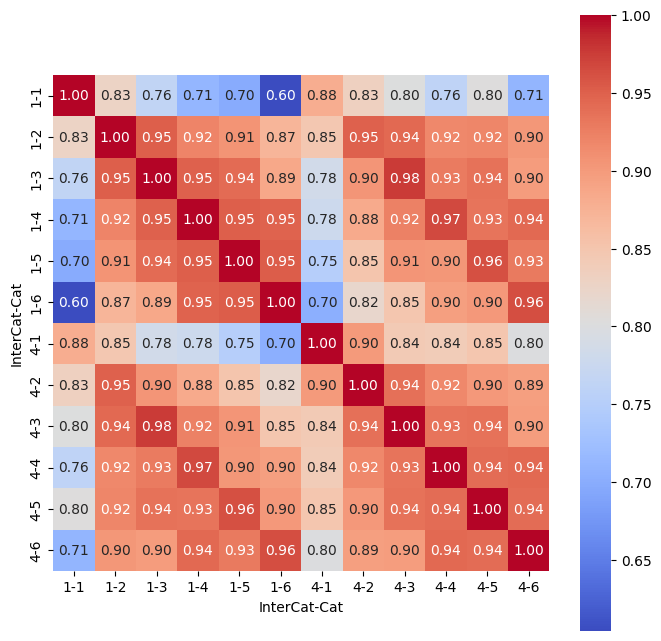

In [223]:
plt.figure(figsize=(8, 8))
sns.heatmap(pd.DataFrame(1-squareform(pdist(x, "cosine")), columns=x.index, index=x.index), cmap="coolwarm", annot=True, fmt=".2f", square=True)